In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

from local_package.ConvNN import preproces

In [ ]:
images = np.load("Datasets/CNN_klass_images(float).npy")
labels = np.load("Datasets/CNN_klass_labels(float).npy")
images, labels = shuffle(images, labels, random_state=25140)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (26126, 256, 256)
Labels shape: (26126,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=25140)

In [34]:
from tensorflow import convert_to_tensor
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return convert_to_tensor(batch_images), convert_to_tensor(batch_labels)
    
    def on_epoch_end(self):
        self.images, self.labels = shuffle(self.images, self.labels)

train_images_gen = DataGenerator(X_train, y_train, 32)
test_images_gen = DataGenerator(X_test, y_test, 32) 


In [35]:
import gc
gc.collect()

8550

In [1]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Concatenate
)
from tensorflow.keras.models import Model


# Input for the source image
source_input = Input(shape=(256, 256, 1), name="source_image")

# First Conv2D layer
x = Conv2D(8, (5, 5), activation="relu", padding="same", strides=(1, 1), use_bias=True)(source_input)

# Merge the resized source image with the resized output of the first layer
merged = Concatenate(axis=-1)([x, source_input])

# Second Conv2D layer
x = Conv2D(128, (5, 5), activation="relu", padding="same", strides=(3, 3), use_bias=True)(merged)
x = Dropout(0.6)(x)
x = MaxPooling2D((2, 2), strides=2, padding='valid')(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(16, activation="relu", use_bias=True)(x)
x = Dense(32, activation="relu", use_bias=True)(x)
output = Dense(1, activation="sigmoid", use_bias=True)(x)

# Create the model
model = Model(inputs=source_input, outputs=output)



# Summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_image (InputLayer)      [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  208         ['source_image[0][0]']           
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 9)  0           ['conv2d[0][0]',                 
                                                                  'source_image[0][0]']           
                                                                                              

In [38]:
conv_layer_with_custom_weights = model.layers[1]
model_weights = conv_layer_with_custom_weights.get_weights()[0]
for x in range(5):
    for y in range(5):
        model_weights[x,y,0,0] = (4-x)/4
        model_weights[y,x,0,1] = (4-x)/4
        model_weights[x,y,0,2] = (x)/4
        model_weights[y,x,0,3] = (x)/4
        # corner gradients
        color = -(4-x)*(4-y)/16 if x > 1 or y > 1 else -0.6
        model_weights[x,y,0,4] = color
        model_weights[4-y,4-x,0,5] = color
        model_weights[4-y,x,0,6] = color
        model_weights[y,4-x,0,7] = color
# apply the custom weights to the convolutional layer
model.layers[1].set_weights([model_weights, np.zeros(8)])

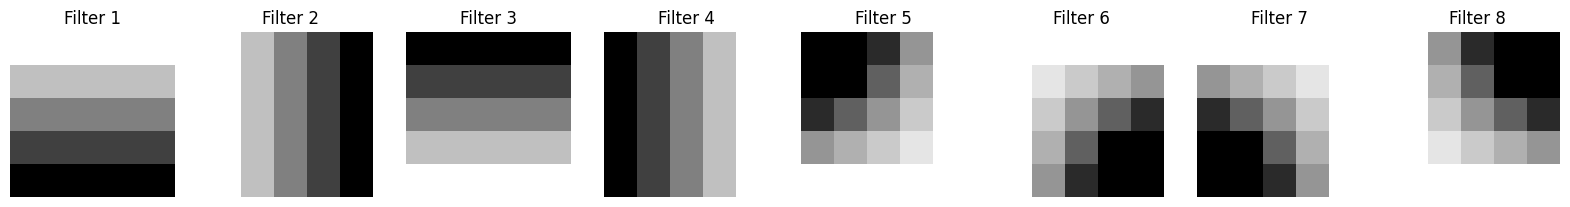

In [39]:
import matplotlib.pyplot as plt

# Get the weights of the convolutional layer
weights = model.layers[1].get_weights()[0]

# Plot the weights
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for i in range(8):
    ax = axes[i]
    ax.imshow(weights[:, :, 0, i], cmap="gray")
    ax.set_title(f'Filter {i+1}')
    ax.axis('off')

plt.show()

In [ ]:

optimizer = SGD(learning_rate=0.01, momentum=0.1)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

checkpoint_path = "tmp/checkpoint_two_inputs_GPU"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

model.fit(train_images_gen, batch_size=16, epochs=15, verbose=1, validation_data=test_images_gen)

Epoch 1/15
572/572 [==============================] - 46s 79ms/step - loss: 0.7903 - accuracy: 0.6227 - val_loss: 0.5674 - val_accuracy: 0.7619
Epoch 2/15
572/572 [==============================] - 46s 80ms/step - loss: 0.6519 - accuracy: 0.6873 - val_loss: 0.6514 - val_accuracy: 0.5685
Epoch 3/15
572/572 [==============================] - 46s 80ms/step - loss: 0.5302 - accuracy: 0.7508 - val_loss: 0.3850 - val_accuracy: 0.8445
Epoch 4/15
572/572 [==============================] - 46s 80ms/step - loss: 0.3798 - accuracy: 0.8354 - val_loss: 0.3316 - val_accuracy: 0.8688
Epoch 5/15
572/572 [==============================] - 46s 80ms/step - loss: 0.3439 - accuracy: 0.8523 - val_loss: 0.4568 - val_accuracy: 0.7829
Epoch 6/15
572/572 [==============================] - 46s 81ms/step - loss: 0.3977 - accuracy: 0.8168 - val_loss: 0.2990 - val_accuracy: 0.8861
Epoch 7/15
572/572 [==============================] - 46s 81ms/step - loss: 0.2500 - accuracy: 0.9050 - val_loss: 0.2618 - val_accuracy:

In [48]:
# save the model
model.save("models/model_two_inputs_GPU.h5")

In [4]:
from tensorflow.keras.models import load_model
model = load_model("models/model_two_inputs_GPU.h5")
# checkpoint_path = "tmp/checkpoint_two_inputs_GPU"
# model.load_weights(checkpoint_path)

In [5]:
testX_new = np.array([preproces(f'./scraped_images/{path}') for path in os.listdir("scraped_images")])/255.0
testY_new = [0 for _ in range(len(testX_new))]
testX_new = np.concatenate((testX_new, np.array([preproces(f'./test_set_cropped/{path}') for path in os.listdir("test_set_cropped")])/255.0))
testY_new = np.concatenate((testY_new, [1 for _ in range(len(testX_new)-len(testY_new))]))

In [9]:
testX_names = np.array([path for path in os.listdir("scraped_images")])
testX_names = np.concatenate((testX_names, np.array([path for path in os.listdir("test_set_cropped")])))

In [22]:
# evaluate the model and optimize the threshold
model.evaluate(testX_new, testY_new)
predictions = model.predict(testX_new)
threshold = 0.5
predictions = (predictions > threshold).astype(int)
from sklearn.metrics import classification_report
print(classification_report(testY_new, predictions))



19/19 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.73      0.59      0.66        69
           1       0.95      0.97      0.96       526

    accuracy                           0.93       595
   macro avg       0.84      0.78      0.81       595
weighted avg       0.92      0.93      0.92       595



In [11]:
prediction = model.predict(testX_new)

19/19 [==============================] - 0s 23ms/step


In [23]:
testY_new.shape, prediction.shape

((595,), (595, 1))

69 526
Pred0
41
92.21 % of the images are classified as not cropped
Pred1
15
97.15 % of the images are classified as cropped


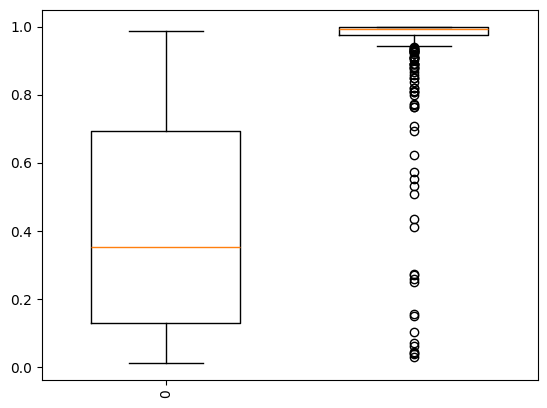

In [31]:
predictions0 = []
predictions1 = []
for i, pred in enumerate(prediction):
    #if not testY[i]:
    if not testY_new[i]:
        predictions0.append(pred[0])
    else:
        predictions1.append(pred[0])

print (len(predictions0), len(predictions1))
try:
    print("Pred0")
    plt.boxplot(predictions0, positions=[0], widths=0.6)
    print(sum(1 for var in predictions0 if var < 0.5))
    print(100-round(sum(1 for var in predictions0 if var < 0.5)/len(predictions1)*100,2), "% of the images are classified as not cropped")
    # print(sum(1 for var in predictions0 if var >= 0.5))
    # print(100-round(sum(1 for var in predictions0 if var >= 0.5)/len(predictions0)*100,2), "% of the images are classified as not cropped")
    print("Pred1")
    plt.boxplot(predictions1, positions=[1], widths=0.6)
    print(sum(1 for var in predictions1 if var < 0.5))
    print(100-round(sum(1 for var in predictions1 if var < 0.5)/len(predictions1)*100,2), "% of the images are classified as cropped")
except Exception as e:
    print(e)
plt.xticks(range(1), rotation=90)
plt.show()

In [ ]:
# GPU
model = Sequential()
model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(256, 256, 1), padding="same", strides=(3, 3), use_bias=True))
model.add(Dropout(0.6))
model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))
model.add(Conv2D(128, (5, 5), activation="relu", padding="same", strides=(3, 3), use_bias=True))
model.add(Dropout(0.6))
model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(8, activation="relu", use_bias=True))
#model.add(Dropout(0.2))
model.add(Dense(16, activation="relu", use_bias=True))
#model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid", use_bias=True))

optimizer = SGD(learning_rate=0.01, momentum=0.1)
# Compile the model
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
# Train the model
#reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.0001, verbose=1)
#checkpoint_path = "tmp/checkpoint_20_0.8CDr"
#model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
model.fit(train_images_gen, batch_size=8, epochs=15, verbose=1, validation_data=test_images_gen)#, callbacks=[model_checkpoint])#, callbacks=[reduce_lr])
#model.save("CNN_model_8_80ep_0.8CDr.h5")

AttributeError: 'Sequential' object has no attribute '_nested_inputs'

In [ ]:

optimizer = SGD(learning_rate=0.01, momentum=0.1)
# Compile the model
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
# Train the model
#reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.0001, verbose=1)
#checkpoint_path = "tmp/checkpoint_20_0.8CDr"
#model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
model.fit(train_images_gen, batch_size=8, epochs=15, verbose=1, validation_data=test_images_gen)#, callbacks=[model_checkpoint])#, callbacks=[reduce_lr])
#model.save("CNN_model_8_80ep_0.8CDr.h5")